# Final Project

## Project Description


The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.



**Interconnect's Services**

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Data Description**

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.




**Model Evaluation**

The target feature for the analysis is where the `'EndDate'` column equals `'No'`. The primary evaluation metric is AUC-ROC, with accuracy as an additional metric. The assessment criteria for the AUC-ROC score are as follows:

- AUC-ROC < 0.75: 0 SP
- 0.75 ≤ AUC-ROC < 0.81: 4 SP
- 0.81 ≤ AUC-ROC < 0.85: 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87: 5 SP
- 0.87 ≤ AUC-ROC < 0.88: 5.5 SP
- AUC-ROC ≥ 0.88: 6 SP

This system assigns points (SP) based on the model's AUC-ROC score, with higher scores reflecting better model performance.

## Setup

### Library Imports

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime
from IPython.display import display
from matplotlib import pyplot as plt
from datetime import datetime

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Sklearn
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

### Data Imports

In [2]:
# Load data -- provide feedback if unsuccessful

try: 
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')
except FileNotFoundError as e:
    print(f'The datasets were not imported: Error {e}')
else:
    print('The datasets were imported successfully')
    
    # Turn off warning
    warnings.filterwarnings('ignore')

The datasets were imported successfully


## Initial Data Exploration

In [3]:
# A dict of datasets to easily print initial info 

datasets = {
    'contract_df': contract_df,
    'personal_df': personal_df,
    'internet_df': internet_df,
    'phone_df': phone_df
}

for name, dataset in datasets.items():
    print(f"Dataset: {name}\n")
    dataset.info()
    display(dataset.head())
    print("\n---------------------------------------------")

Dataset: contract_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



---------------------------------------------
Dataset: personal_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



---------------------------------------------
Dataset: internet_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



---------------------------------------------
Dataset: phone_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



---------------------------------------------


### Notes on the Datasets

1) Contract Database
    - There are no missing values
    - Pre-processing
        - Change column names to underscored-lowercase names
        - Check for duplicates in the dataset
        - Change the BeginDate column to datetime
        - Change TotalCharges to a float64 value type
        
    - Feature Engineering
        - Feature engineer columns for `date`, `month`, `year` from the `BeginDate` and `EndDate` columns
        - Create a new column based on EndDate to say if customer has left or not left the service
        - Check seasonality for BeginDate column (month, day of the week, hour)
        - One hot encode the PaymentMethod, PaperlessBilling, and Type columns.


2) Personal Database
    - There are no missing values
    - Preprocessing:
        - Change column names to underscore lowercase
        - Check for duplicates in the dataset

    - Feature Engineering:
        - One hot encode the gender, Partner, and Dependents columns

3) Internet Database
    - There are no missing values
    - There are 1526 fewer customer ID's then internet and personal DFs. 
        - This discrepancy may be explained by the fact that they did not subscribe to any internet service.
        
    - Preprocessing:
        - Change column names to underscore lowercase
        - Check for duplicates in the dataset

    - Feature Engineering:
        - One hot encode all columns except for customer ID.

4) Phone Database
    - There are no missing values
    - There are 682 fewer customer ID's then internet and personal DFs. 
        - This discrepancy may be explained by the fact that they did not subscribe to any phone service.
        
    - Preprocessing:
        - Change column names to underscore lowercase
        - Check for duplicates in the dataset

    - Feature Engineering:
        - One hot encode the MultipleLines column

## Proposed Work Plan

**Objective:** Build a model to predict user churn.

Procedure:
1. Download the dataset.
2. Examine the dataset to identify suitable preprocessing techniques.
3. Prepare the data:
    - Merge all dataframes into a single primary dataframe.
    - Standardize column names to underscore-lowercase format.
    - Convert columns to the appropriate data types.
4. Conduct a comprehensive exploratory data analysis (EDA).
5. Perform feature engineering.
6. Train and evaluate models:
    - Compare different classification models against a baseline, including:
        - Logistic Regression
        - Decision Tree Classifier
        - Random Forest Classifier
        - LightGBM
    - Evaluate models using ROC-AUC and accuracy metrics.
    - Optimize models with cross-validation and gradient boosting techniques.
7. Validate the final model on the test set.
8. Organize the code logically.
9. Write the conclusion.
    - Declare global functions at start of file


## Global Functions

In [4]:
# Function for formatting text

def format_name(word):
    words = word.replace("_", " ").split()
    formatted_words = [w[0].upper() + w[1:].lower() for w in words]
    return ' '.join(formatted_words)

In [5]:
# Function to upsample the data

def upsample(features, target, repeat):
    # Separate features and target by class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Upsample the minority class
    upsampled_features = pd.concat([features_zeros] + [features_ones] * repeat, axis=0)
    upsampled_target = pd.concat([target_zeros] + [target_ones] * repeat, axis=0)

    # Shuffle the dataset
    upsampled_features, upsampled_target = shuffle(upsampled_features, upsampled_target, random_state=12345)

    return upsampled_features, upsampled_target

In [6]:
# Function to scale numerical features

def scale_features(features, numeric_columns):
    scaler = MinMaxScaler()    
    scaler.fit(features[numeric_columns])
    scaled_features = scaler.transform(features[numeric_columns])
    features[numeric_columns] = scaled_features
    return features

In [7]:
# Function to split data into 3:1:1 ratio

def split_data_3_1_1(features, target, final_test_size=0.40, random_state_value=42):
    '''Splits features and target into train, validation, and test datasets,
    and prints the split ratio used. Returns 6 variables: train features, validation features,
    test features, train target, validation target, and test target respectively.'''
    
    # Splitting the source data into 40% for Validation and 60% for Training
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=final_test_size, random_state=random_state_value)
    
    # Further splitting the validation data to obtain 3:1:1 ratio
    X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.50, random_state=random_state_value)
    
    # Printing confirmation of data split
    total_data_size = len(features)
    split_sizes = len(X_train) + len(X_valid) + len(X_test)
    
    if total_data_size == split_sizes:
        print(f"Data split ratio is 3:1:1, where data is allocated as:\n"
              f"Training = 60% (n={len(X_train)})\n"
              f"Validation = 20% (n={len(X_valid)})\n"
              f"Testing = 20% (n={len(X_test)})")
    else:
        print("Warning: Data split did not match the expected total size.")
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
# Function to evaluate the model

def evaluate_model(model, X_valid, y_valid):
    """Evaluates the model on the validation set using AUC-ROC and Accuracy."""
    
    # Get predictions for validation set
    y_pred_proba = model.predict_proba(X_valid)[:, 1] 
    y_pred = model.predict(X_valid) 

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_valid, y_pred_proba)

    # Calculate Accuracy
    accuracy = accuracy_score(y_valid, y_pred)

    # Return the results
    return {
        "AUC-ROC": float(format(auc_roc, '.4f')),
        "Accuracy": float(format(accuracy, '.4f'))
    }

In [9]:
# Function to perform grid search for best parameters

def search_best_model(model, params, X_train, y_train, cv=5, scoring_method='roc_auc', num_jobs=-1, verbosity=0):
    # Define GridSearchCV with a combined parameter grid
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring=scoring_method,
        n_jobs=num_jobs,
        verbose=verbosity
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_model = grid_search.best_estimator_
    
    # Print best score
    print("Best Model:", best_model)
    print("Best ROC AUC Score:", grid_search.best_score_, '\n')
    
    # return model
    return best_model

## Data Pre-Processing

### Renaming columns

In [10]:
# Standardize column names to underscore-lowercase format

contract_df = contract_df.rename(
    columns={
        'customerID': 'customer_id', 
        'BeginDate': 'begin_date',
        'EndDate': 'end_date',
        'Type': 'type',
        'PaperlessBilling': 'paperles_billing',
        'PaymentMethod': 'payment_method',
        'MonthlyCharges': 'monthly_charges',
        'TotalCharges': 'total_charges'
    }
)

personal_df = personal_df.rename(
    columns={
        'customerID': 'customer_id', 
        'gender': 'gender',
        'SeniorCitizen': 'senior_citizen',
        'Partner': 'partner',
        'Dependents': 'dependents',
    }
)

internet_df = internet_df.rename(
    columns={
        'customerID': 'customer_id', 
        'InternetService': 'internet_service',
        'OnlineSecurity': 'online_security',
        'OnlineBackup': 'online_backup',
        'DeviceProtection': 'device_protection',
        'TechSupport': 'tech_support',
        'StreamingTV': 'streaming_tv',
        'StreamingMovies': 'streaming_movies',
    }
)

phone_df = phone_df.rename(
    columns={
        'customerID': 'customer_id', 
        'MultipleLines': 'multiple_lines',
    }
)

### Merging Data

In [11]:
# Merge all datasets into one dataset

df = (
    contract_df
    .merge(personal_df, on='customer_id', how='outer')
    .merge(phone_df, on='customer_id', how='outer')
    .merge(internet_df, on='customer_id', how='outer')
)

In [12]:
# Sanity check to confirm data was not lost

larget_dataset = 0
for dataset in datasets:
    current_dataset_lenth = len(datasets[dataset])
    if current_dataset_lenth > larget_dataset:
        larget_dataset = current_dataset_lenth
        
if larget_dataset == len(df):
    print('Datasets match; No data lost!')
else:
    print('Datasets do not match; Potential data loss!')

Datasets match; No data lost!


### Handling Missing Values

In [13]:
# Observe new dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperles_billing   7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

Upon closely examining the joint dataset, it was discovered that the following columns contain missing values:
- `multiple_lines`
- `internet_service`
- `online_security`
- `online_backup`
- `device_protection`
- `tech_support`
- `streaming_tv`
- `streaming_movies`

Each of these columns typically contains either a `'Yes'` or `'No'` value, or in the case of the `internet_service` column, a string representing the type of internet service (e.g., fiber optic or DSL). Empty cells will be interpreted as the customer not subscribing to the respective feature, and will therefore be filled with `'No'`.


In [14]:
# Fill missing values with 'No' and observe dataset
df = df.fillna('No')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperles_billing   7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

Columns with the `object` dtype can be incorrectly classified as containing data when they actually have empty strings. This can be problematic for columns that should strictly have `int64` or `float64` dtypes but are instead of the `object` dtype.

In [15]:
# Check the object columns for empty spaces that are wrongly classified as a non-missing value

for col in df:
    if df[col].eq(' ').any():
        print(col)

total_charges


In [16]:
# Find the number of rows in the `total_charges` with empty values
number_total_charges_empty = (df['total_charges'] == ' ').sum()
print(f'Number of empty total_charges: {number_total_charges_empty}')

# If the number of cells is less than 5% of data, they can be removed from the dataset
if number_total_charges_empty < 0.05 * len(df):
    df = df.loc[df['total_charges'] != ' ']
    df.reset_index(drop=True, inplace=True) 
    print('Less than 5%; Empty cells removed!')
else:
    print('More than 5%')

Number of empty total_charges: 11
Less than 5%; Empty cells removed!


df.info()

Certain columns in the dataset need to be converted to different `Dtypes`. Specifically, `total_charges` should be changed from `object` to `float64`, and `begin_date` should be converted from `object` to `datetime[ns]`.

The dataset **must** be inspected for duplicate entries, specifically focusing on the `customer_id` column. While duplicates may occur in other columns such as `total_charges`, `monthly_charges`, or `internet_service`, these will not be verified. It is common for multiple customers to share the same values in these fields.


### Handling Data Type Conversion

In [17]:
# Convert columns to correct Dtype

df['total_charges'] = df['total_charges'].astype('float64')
df['begin_date'] = pd.to_datetime(df['begin_date'])

### Handling Duplicates

In [18]:
# Check for any duplicates customers

df['customer_id'].duplicated().sum()

0

### Column Additions

The `end_date` column indicates whether a customer is still with the company or has left (and disconnected their services). If the `end_date` value is `'No'`, it should be interpreted as the customer still being with the company.

To facilitate exploratory data analysis (EDA) and model training, consider creating a new column where `0` represents `'No'` (still with the company) and `1` represents `'Yes'` (has left).

In [19]:
# Create a column called 'customer_churn' based on 'end_date' to be either 0 or 1 (0 is No)

df['customer_churn'] = np.where(df['end_date'] == 'No', 0, 1)

## EDA

In this Exploratory Data Analysis (EDA), the focus will be primarily on monthly charges rather than total charges. Total charges represent the accumulated amount a customer has accrued over their entire tenure with the company, meaning that customers who have been with the company longer will naturally have higher total charges due to the accumulation over time.

By concentrating on monthly charges, the analysis can provide insights into cost trends and patterns on a per-period basis. This approach offers a more balanced view of the charges that is not influenced by the duration of the customer's relationship with the company, allowing for a more equitable comparison of customer costs and helping to identify trends or anomalies related to billing practices or customer behavior.

In [20]:
# Copy existing DataFrame to prevent adding excess columns to the official dataset at this time

df_copy = df.copy()

# Drop 'customer_id' because it is not needed for EDA
df_copy = df.drop(['customer_id'], axis=1)

### Analysis of Average Monthly Charges Over Time

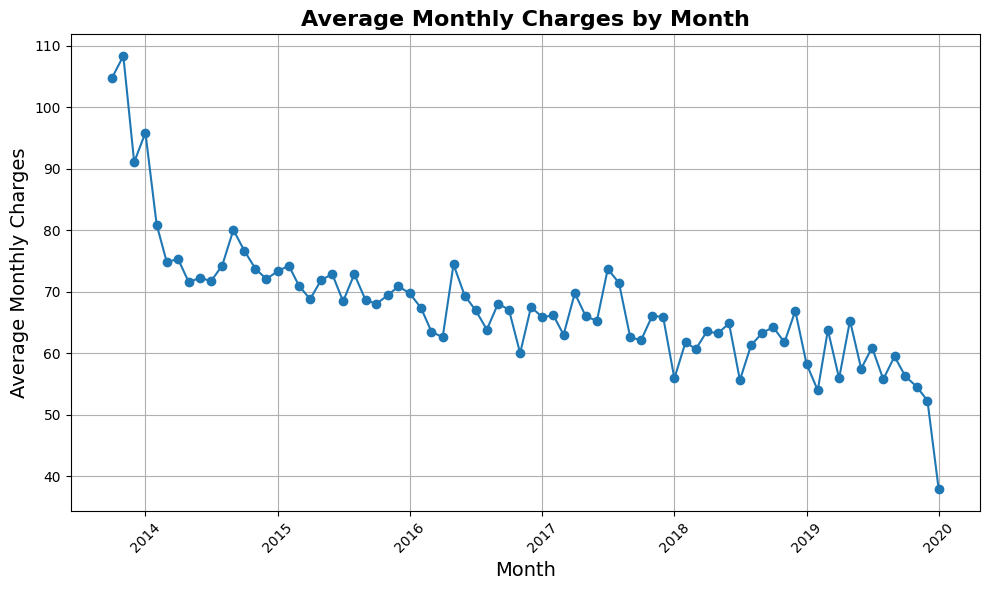

In [21]:
# Plot a time-series of the monthly trends

# Convert 'begin_date' to datetime, extract month, aggregate by month, convert 'month' back to datetime
df_copy['begin_date'] = pd.to_datetime(df_copy['begin_date'])
df_copy['month_year'] = df_copy['begin_date'].dt.to_period('M') 
monthly_charges_by_month = df_copy.groupby('month_year')['monthly_charges'].mean().reset_index()
monthly_charges_by_month['month_year'] = monthly_charges_by_month['month_year'].dt.to_timestamp()


plt.figure(figsize=(10, 6))
plt.plot(monthly_charges_by_month['month_year'], monthly_charges_by_month['monthly_charges'], marker='o', linestyle='-')
plt.title('Average Monthly Charges by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Monthly Charges', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data indicates that at the end of 2013, the average monthly charges were approximately 100 USD. Since then, there has been a consistent decline in these charges. However, a closer look reveals a notable drop immediately following 2013, lasting until around mid-2014, when the average fell to about 75 USD. After mid-2014, the average continued to decrease, with occasional increases between months, but the overall trend remained downward. This downward trend continued with less significant decreases until 2020, when another substantial drop occurred in the average monthly charges.

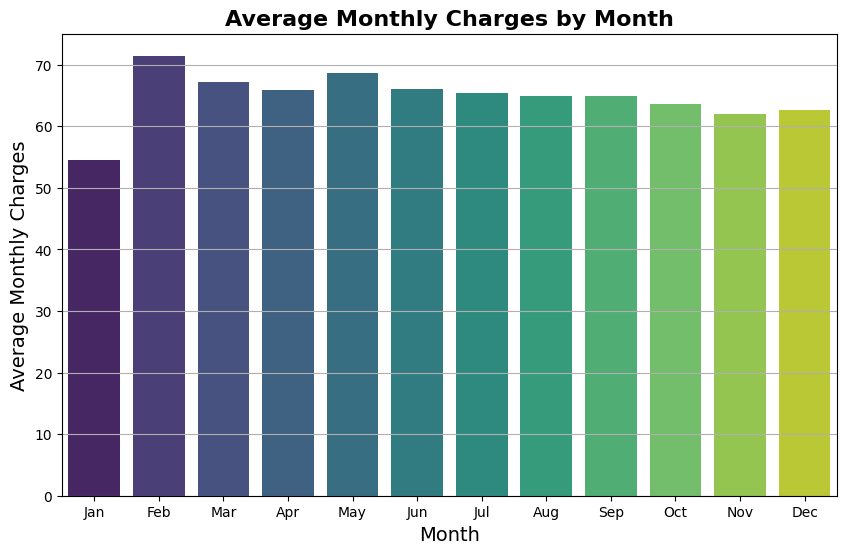

In [22]:
# Plot month with the highest average monthly charges across all years

df_copy['begin_month'] = df_copy['begin_date'].dt.month
df_copy['begin_year'] = df_copy['begin_date'].dt.year
df_copy['begin_dow'] = df_copy['begin_date'].dt.dayofweek

monthly_avg_charges = df_copy.groupby('begin_month')['monthly_charges'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='begin_month', y='monthly_charges', data=monthly_avg_charges, palette='viridis')

plt.title('Average Monthly Charges by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Monthly Charges', fontsize=14)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')

plt.show()

The table displays the overall monthly averages. Analyzing the entire dataset reveals that, on average, there is no significant variation in the mean monthly charges, except for January, which has consistently been lower. This trend may be influenced by the fact that January 2020 recorded the lowest average monthly charges ever.

### Analysis of Monthly Charges Across Different Categorical Groups

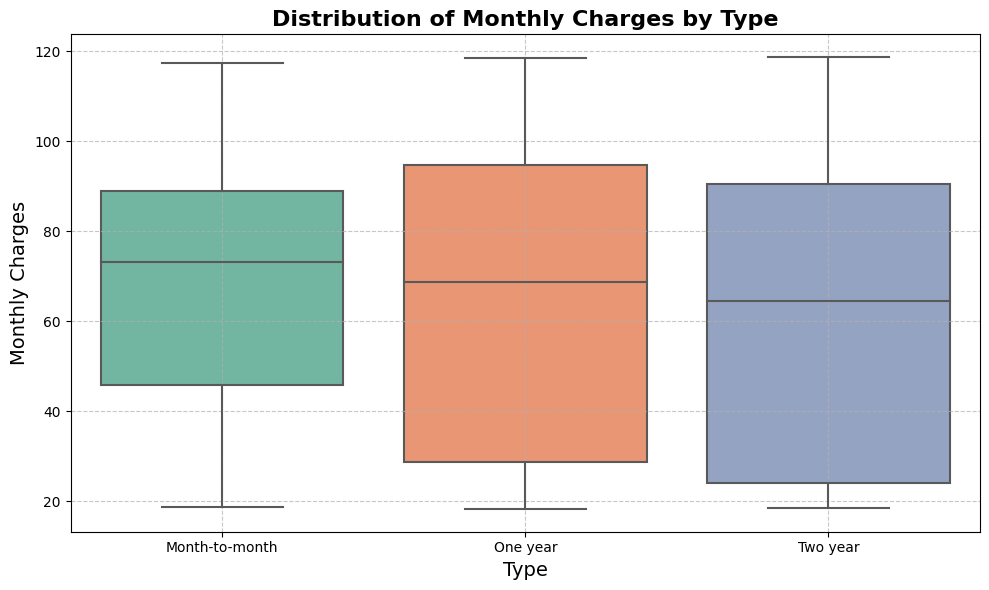

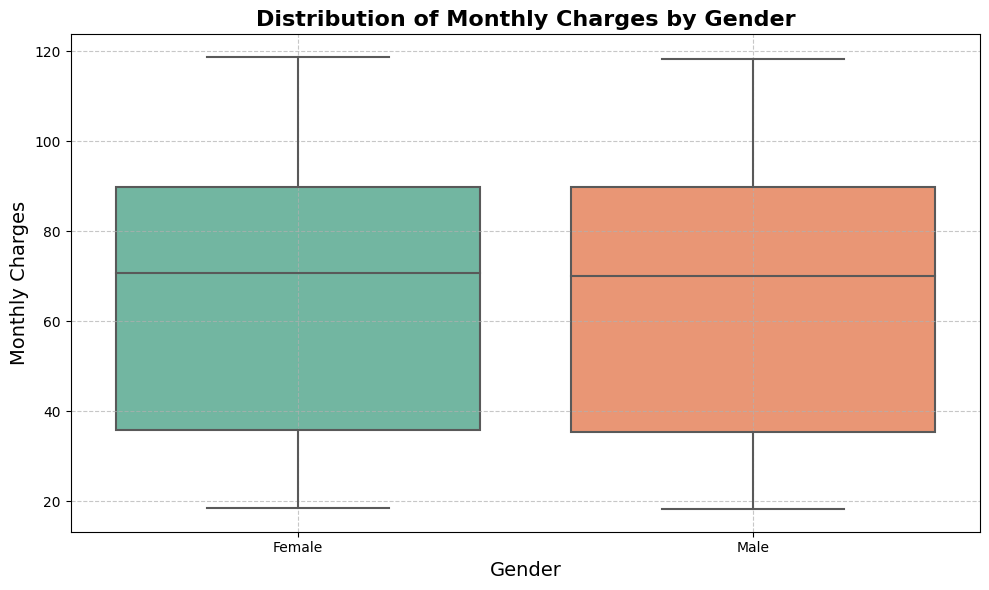

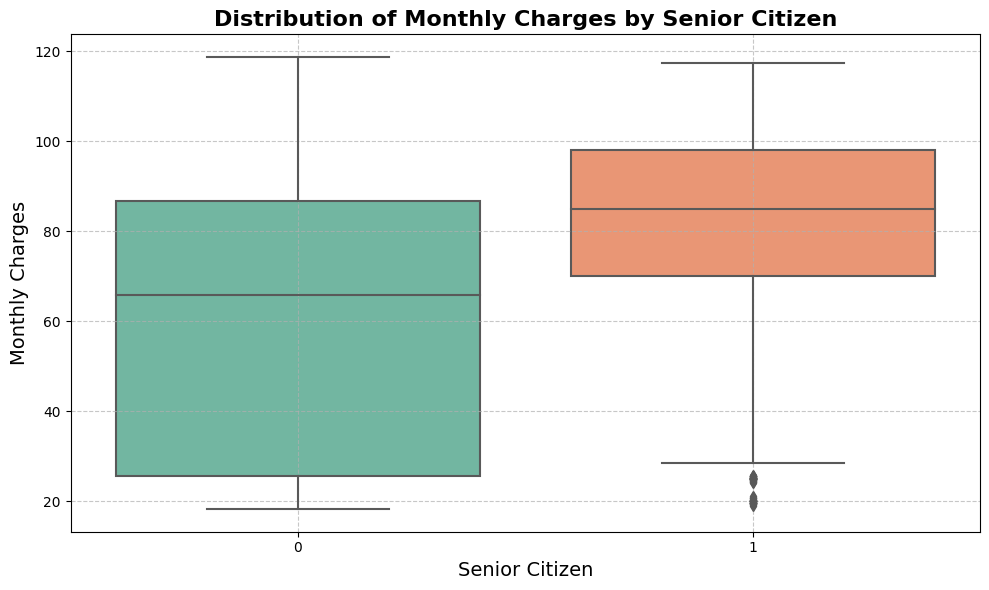

In [23]:
# Distribution of Monthly Charges by Type, Gender and Senior Citizen Status

for num_col in ['monthly_charges']:
    for cat_col in ['type', 'gender', 'senior_citizen']:
        x_title = format_name(cat_col)
        y_title = format_name(num_col)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cat_col, y=num_col, data=df_copy, palette='Set2')
        
        plt.title(f'Distribution of {y_title} by {x_title}', fontsize=16, fontweight='bold')
        plt.xlabel(x_title, fontsize=14)
        plt.ylabel(y_title, fontsize=14)        
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

Observing the data, several insights emerge regarding the distribution of monthly charges across different categorical groups:

- **Contract Type**: The median monthly charges for month-to-month, one-year, and two-year contracts are relatively similar, though month-to-month contracts have the highest median. Interestingly, month-to-month users exhibit the smallest variability in monthly charges.
  
- **Gender**: The distribution of monthly charges between males and females is almost identical, with median charges being comparable for both genders. This indicates that monthly charges do not significantly differ by gender.

- **Senior Citizen Status**: Senior citizens generally incur higher average monthly charges compared to younger individuals. The median monthly charges are notably higher for senior citizens.

### Impact of Paperless Billing on Total Charges


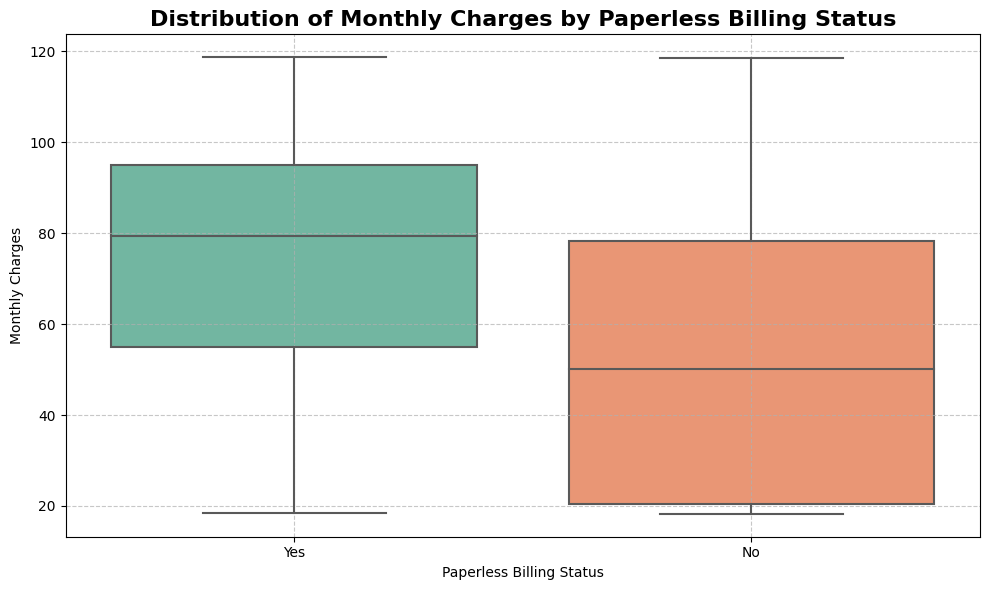

In [24]:
# Boxplot for monthly charges by paperless billing status

plt.figure(figsize=(10, 6))
sns.boxplot(x='paperles_billing', y='monthly_charges', data=df_copy, palette='Set2')
plt.title('Distribution of Monthly Charges by Paperless Billing Status', fontsize=16, fontweight='bold')
plt.xlabel('Paperless Billing Status')
plt.ylabel('Monthly Charges')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The analysis reveals that customers who opt for paperless billing tend to have higher median monthly charges compared to those who do not use paperless billing. This indicates a noticeable difference in billing patterns, with paperless billing users generally incurring higher average monthly expenses. 

The distribution of monthly charges for paperless billing users shows a higher median value, suggesting that this billing option is associated with increased costs. This trend may reflect different usage patterns or service preferences among customers who choose paperless billing.


### Visualization of Monthly and Total Charges Distribution with Histograms and KDE

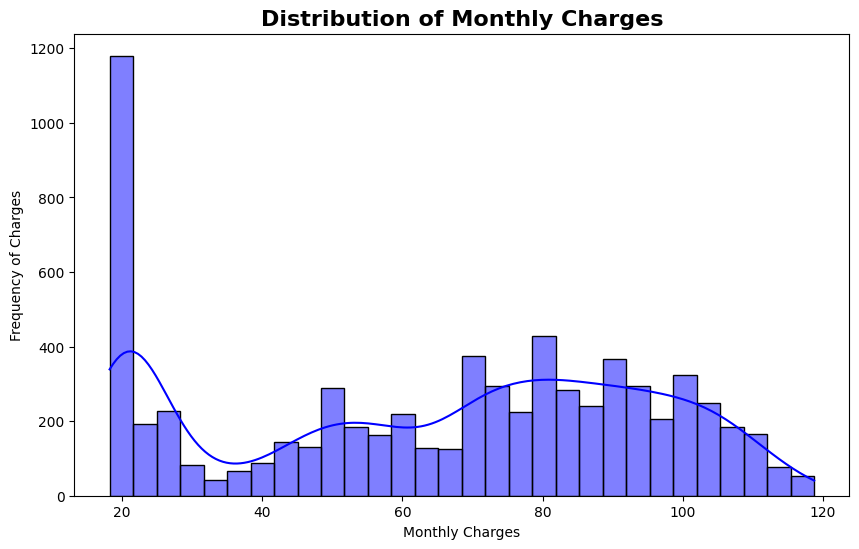

In [25]:
# Plot histograms and KDE (Kernel Density Estimate) plots for the monthly_charges

plt.figure(figsize=(10, 6))
sns.histplot(df_copy['monthly_charges'], kde=True, color='blue', bins=30)
plt.title('Distribution of Monthly Charges', fontsize=16, fontweight='bold')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency of Charges')
plt.show()

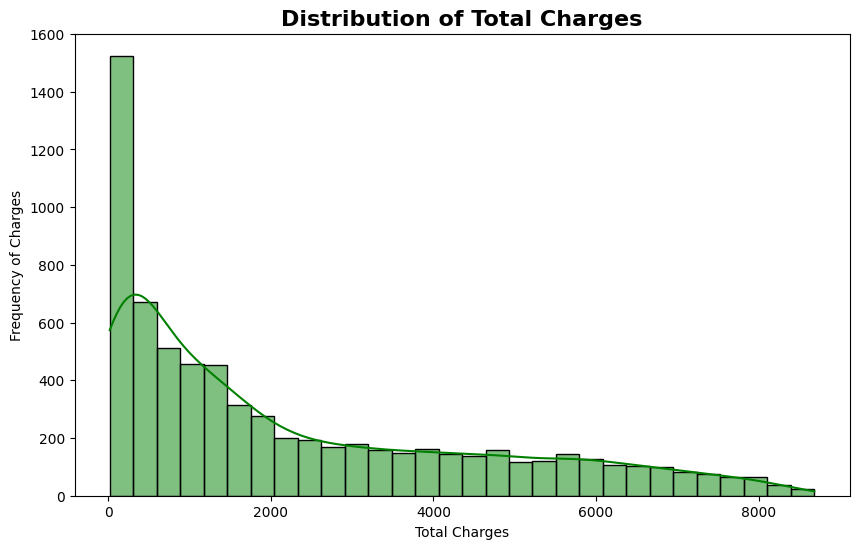

In [26]:
# Plot histograms and KDE (Kernel Density Estimate) plots for the total_charges

plt.figure(figsize=(10, 6))
sns.histplot(df_copy['total_charges'], kde=True, color='green', bins=30)
plt.title('Distribution of Total Charges', fontsize=16, fontweight='bold')
plt.xlabel('Total Charges')
plt.ylabel('Frequency of Charges')
plt.show()


### Correlation Matrix of Numeric Columns

In [27]:
# Compute and print the correlation matrix for numeric columns

correlation_matrix = df_copy.corr()

print(correlation_matrix)

                 monthly_charges  total_charges  senior_citizen  \
monthly_charges         1.000000       0.651065        0.219874   
total_charges           0.651065       1.000000        0.102411   
senior_citizen          0.219874       0.102411        1.000000   
customer_churn          0.192858      -0.199484        0.150541   
begin_month            -0.019613      -0.196624        0.028569   
begin_year             -0.263086      -0.819304       -0.027386   
begin_dow               0.032153       0.055044        0.005410   

                 customer_churn  begin_month  begin_year  begin_dow  
monthly_charges        0.192858    -0.019613   -0.263086   0.032153  
total_charges         -0.199484    -0.196624   -0.819304   0.055044  
senior_citizen         0.150541     0.028569   -0.027386   0.005410  
customer_churn         1.000000     0.180522    0.293770   0.027360  
begin_month            0.180522     1.000000    0.084872   0.046143  
begin_year             0.293770     0.08487

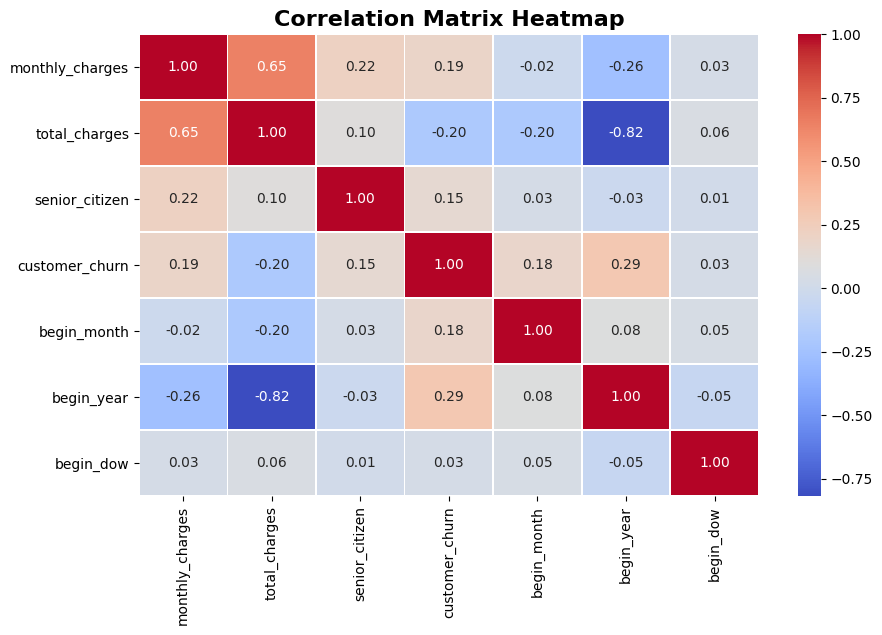

In [28]:
# Plot the correlation matrix

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.show()


The correlation matrix reveals the following relationships between `monthly_charges`, `total_charges`, `senior_citizen`, and `customer_churn`:

- **Monthly Charges**: There is a moderate positive correlation (r = 0.65) between `monthly_charges` and `total_charges`, indicating that as monthly charges increase, total charges tend to increase as well. Additionally, `monthly_charges` has a weak positive correlation with `customer_churn` (r = 0.19), suggesting that higher monthly charges may be slightly associated with an increased likelihood of customer churn.

- **Total Charges**: `Total_charges` shows a weak negative correlation with `customer_churn` (r = -0.20), implying that customers with higher total charges may be slightly less likely to churn.

- **Senior Citizen**: The `senior_citizen` variable has a weak positive correlation with both `monthly_charges` (r = 0.22) and `customer_churn` (r = 0.15), suggesting that senior citizens may pay slightly higher monthly charges and have a slightly higher likelihood of churning.

Overall, while there are some associations among the variables, none of the correlations are particularly strong, indicating that other factors may be more influential in determining customer churn.


### Percent of Churned vs. Non-Churned Customers

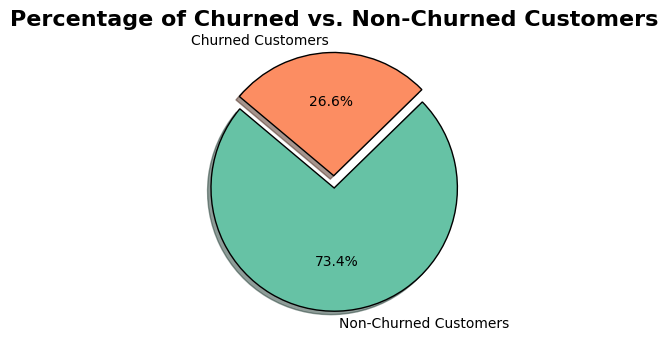

In [29]:
# Compare the percentage of churn_customers

churn_counts = df_copy['customer_churn'].value_counts()
plt.figure(figsize=(6, 4))

plt.pie(
    churn_counts, 
    autopct='%1.1f%%',
    colors=['#66c2a5', '#fc8d62'], 
    labels=['Non-Churned Customers', 'Churned Customers'],
    explode=(0, 0.1),  
    shadow=True,
    startangle=140,  
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Percentage of Churned vs. Non-Churned Customers', fontsize=16, fontweight='bold')
plt.show()

The data indicates that approximately 3/4 of customers remain with the company, while about 26.6% have been classified as churned. This suggests a customer retention rate of around 75%, with a significant portion of the customer base having left the company. The churn rate highlights the need for strategies to improve customer retention and reduce attrition, as nearly a quarter of the customer base has discontinued their service.

,count
begin_month,
1,529
2,671
3,483
4,413
5,368
6,390
7,376
8,381
9,366


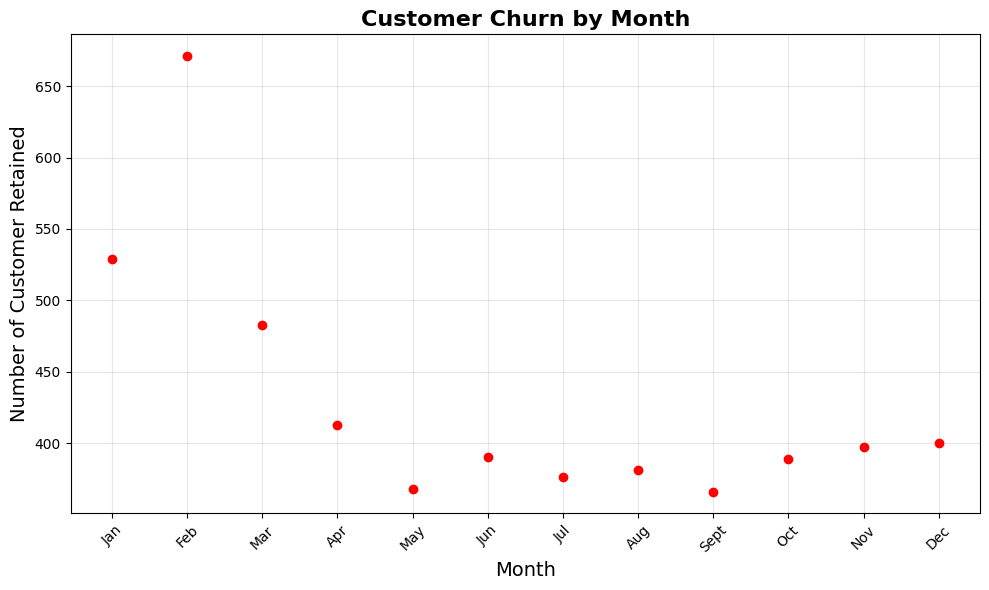

In [30]:
# Show number of customers retained by month joined

# Group by 'begin_month' and count occurrences
month_df = df_copy[df_copy['customer_churn'] == 0].groupby('begin_month').size().reset_index(name='count').set_index('begin_month')
display(month_df)

plt.figure(figsize=(10, 6))
plt.plot(month_df.index, month_df['count'], marker='o', linestyle='', color='red')  # Changed marker color to red
plt.title('Customer Churn by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Customer Retained', fontsize=14)
plt.grid(True, alpha=0.3)  # Set grid transparency
plt.xticks(ticks=month_df.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

The analysis of customer retention by the month of joining reveals several key insights. February, with 671 retained customers, stands out as the month with the highest retention rate, suggesting that customers who join during this period are more likely to stay with the company. This could be attributed to specific marketing campaigns, seasonal trends, or other underlying factors that warrant further investigation. On the other hand, September, with only 366 retained customers, has the lowest retention rate, indicating potential issues with customer engagement or external influences affecting those who join in that month.

A noticeable trend emerges where the number of retained customers is higher in the earlier months of the year (January through March), followed by a gradual decline in the middle of the year. Retention numbers appear to stabilize toward the end of the year.

This analysis uncovers significant patterns in customer retention, highlighting the influence of the month of joining on retention rates. The variation between months suggests that specific factors impact retention, and understanding these could lead to optimized retention strategies. Moreover, identifying why certain months perform better could provide valuable insights for enhancing future marketing and customer engagement efforts.

### Visualization of Class Imbalance

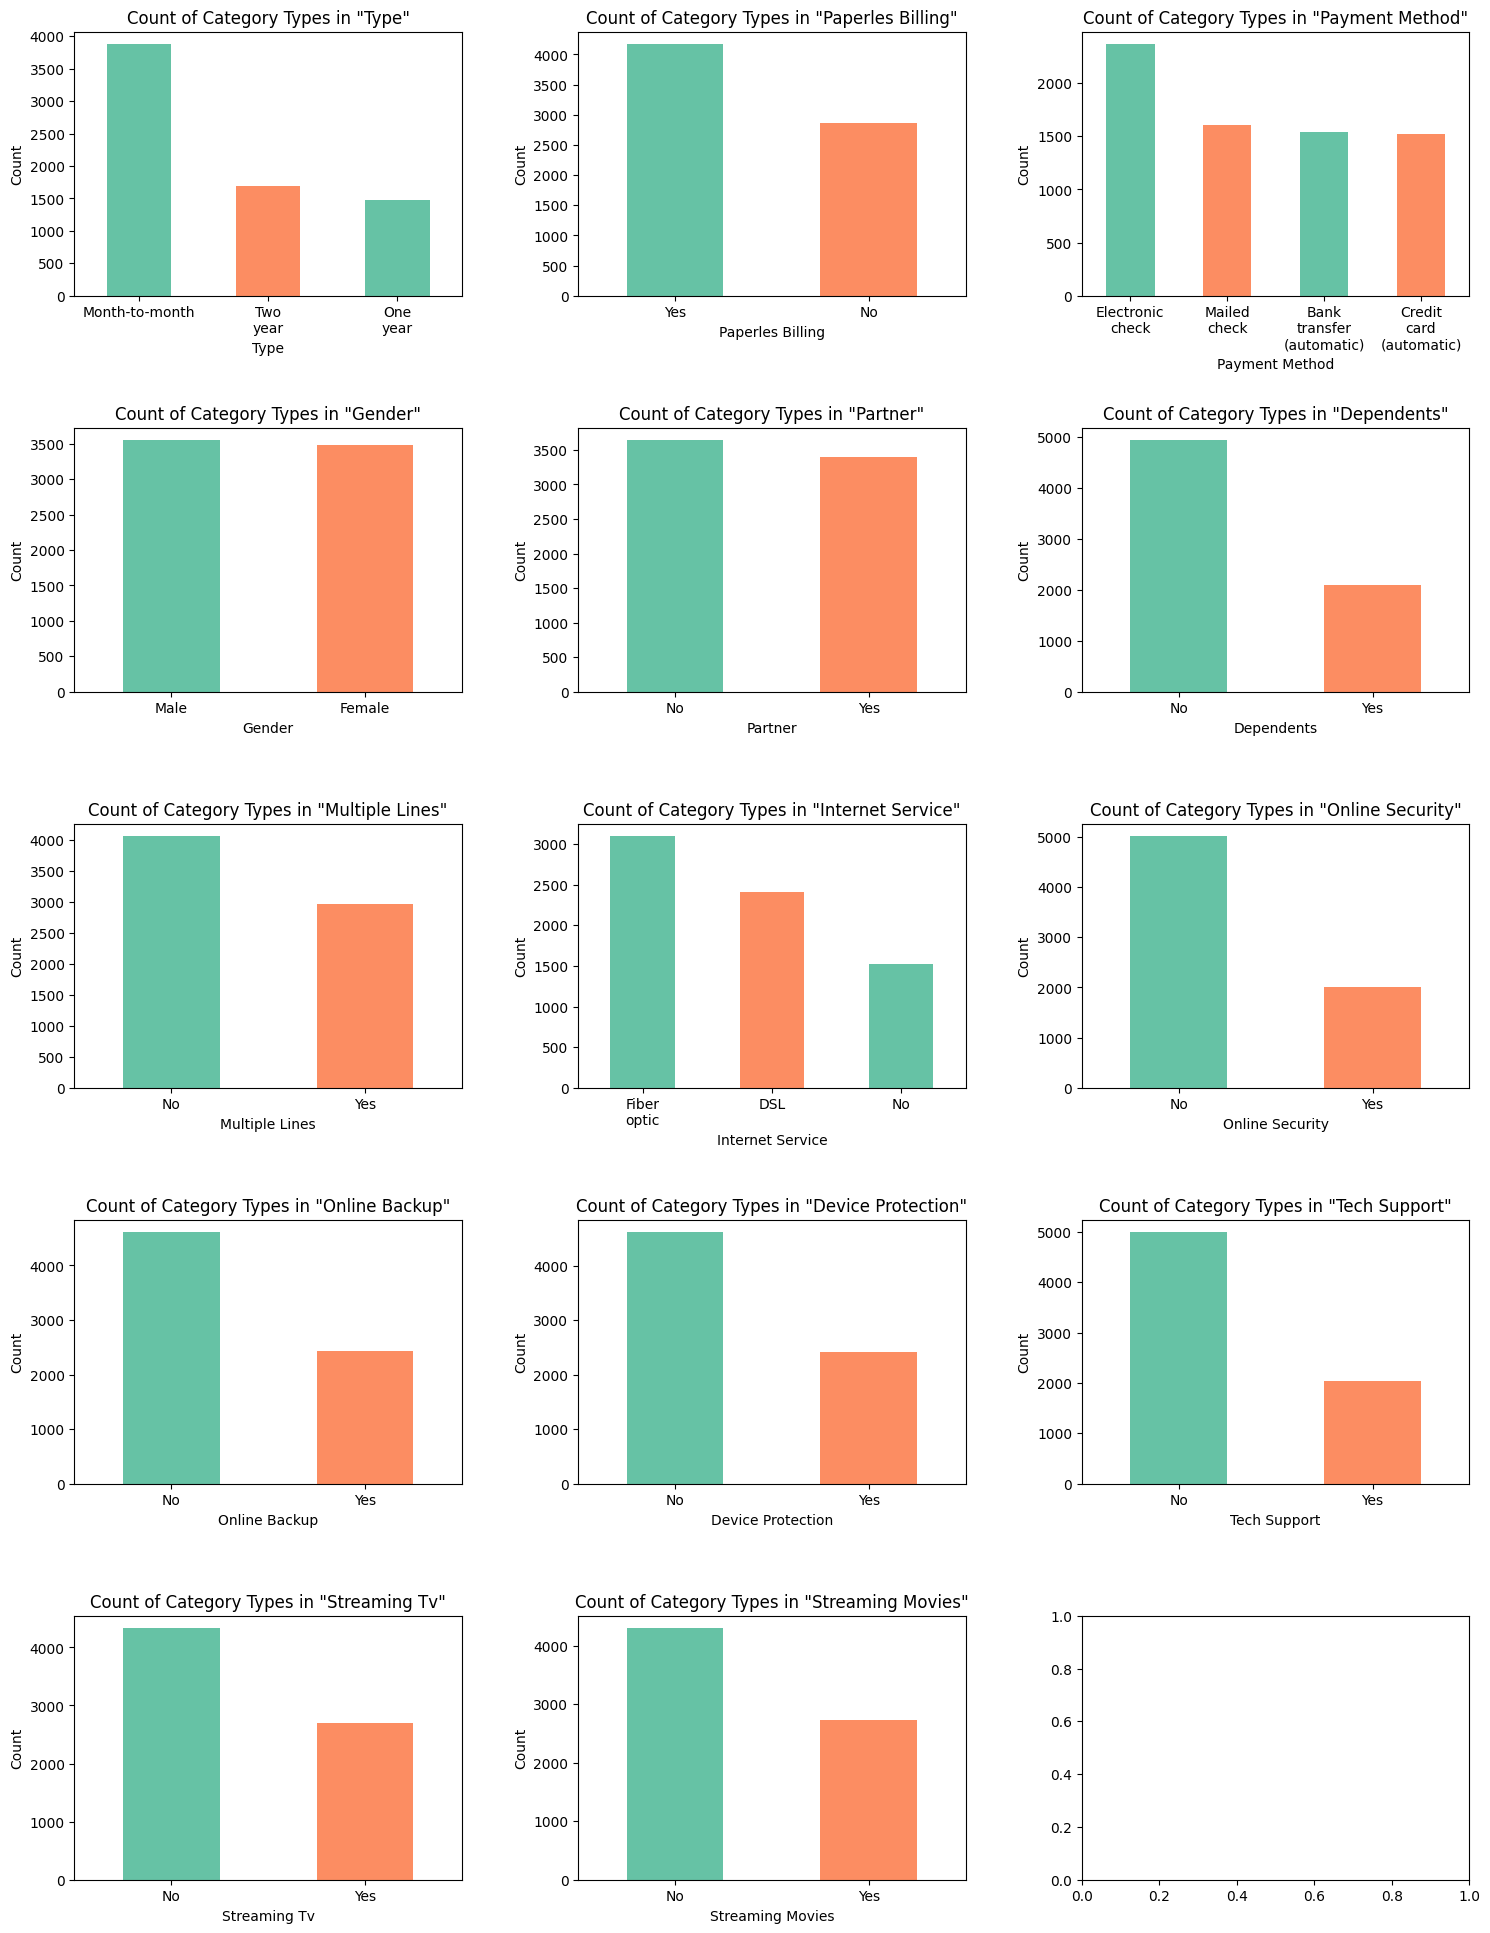

In [31]:
# Visualize Class Imbalances in Categorical Columns

categorical_columns = ['type', 'paperles_billing', 'payment_method', 'gender', 
                       'partner', 'dependents', 'multiple_lines', 'internet_service',
                       'online_security', 'online_backup', 'device_protection', 
                       'tech_support', 'streaming_tv', 'streaming_movies']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))

for i, column in enumerate(categorical_columns):
    formatted_name = format_name(column)
    ax = axes.flatten()[i]
    df_copy[column].value_counts().plot(kind='bar', ax=ax, color=['#66c2a5', '#fc8d62'])
    ax.set_title(f'Count of Category Types in "{formatted_name}"')
    ax.set_xlabel(formatted_name)
    ax.set_ylabel('Count')
    labels = [label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0, ha='center') 
    
plt.subplots_adjust(hspace=0.5, wspace=0.3) 

plt.show()

There is a noticeable class imbalance across various categorical variables, except for the `gender` and `partner` columns, which have relatively balanced counts.

Most categorical variables contain values of either `'Yes'` or `'No'`, except for the `internet_service` column, which includes two service options plus `'No'`. These categorical variables are candidates for one-hot encoding, which will convert them into numerical format. After encoding, class imbalance handling techniques, such as upsampling or downsampling, may be necessary to address the imbalance.

## Data Preparation

### Feature Engineering


In [32]:
# Create features based on the begin_date column

df['begin_year'] = df['begin_date'].dt.year
df['begin_month'] = df['begin_date'].dt.month
df['begin_dow'] = df['begin_date'].dt.dayofweek

In [33]:
# Drop 'customer_id', 'begin_date', 'end_date' because they is not needed for model training

df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

### Encoding

#### One-Hot Encoding

In [34]:
# One-hot encode 

categorical_columns_one_hot = ['type', 'paperles_billing', 'payment_method', 'gender', 'partner',
    'dependents', 'multiple_lines', 'internet_service', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

df = pd.get_dummies(df, columns=categorical_columns_one_hot, drop_first=True)

### Raw Feature and Target Decalaration

In [35]:
# Declare raw features and target

features_raw = df.drop('customer_churn', axis=1)
target_raw = df['customer_churn']

### Handling Class Imbalance

Given the relatively small size of the dataset, upsampling techniques will be employed to increase its size and enhance model performance, aiming to improve the representation of the minority class without losing any data.

#### Upsampling the Data

In [36]:
# Upsample the data 

upsampled_features, upsampled_target = upsample(features_raw, target_raw, 3)

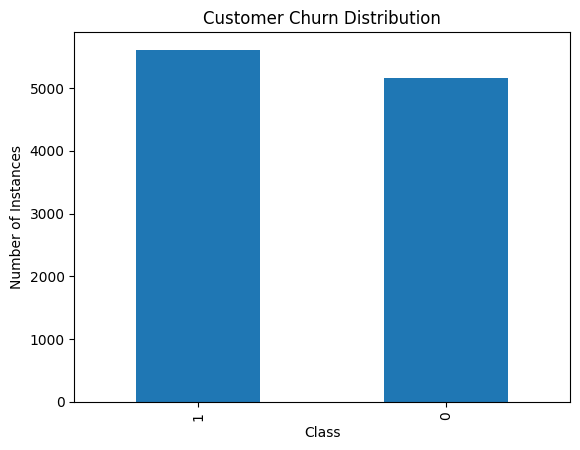

In [37]:
# Check class imbalance again!

class_counts = upsampled_target.value_counts()
class_distribution = upsampled_target.value_counts(normalize=True) * 100

class_counts.plot(kind='bar')
plt.title('Customer Churn Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

### Scaling

#### Feature Scaling

In [38]:
# Scale the upsampled features

numeric_columns = ['monthly_charges', 'total_charges', 'begin_year','begin_month', 'begin_dow']

scaled_features = scale_features(upsampled_features, numeric_columns)

In [39]:
# Confirm features were scaled and data was not lost

if len(scaled_features) == len(upsampled_features):
    print("Length matches")

# View first 5 rows
scaled_features.head()

Length matches


,monthly_charges,total_charges,senior_citizen,begin_year,begin_month,begin_dow,type_One year,type_Two year,paperles_billing_Yes,payment_method_Credit card (automatic),...,dependents_Yes,multiple_lines_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes
4017,0.067662,0.019750,0,0.857143,0.545455,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3351,0.407463,0.004662,0,0.857143,1.000000,1.000000,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
5576,0.010448,0.000058,0,0.857143,0.909091,0.666667,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2919,0.560199,0.093001,0,0.714286,1.000000,0.833333,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3594,0.656219,0.476258,1,0.285714,0.636364,0.833333,0,0,1,0,...,1,1,1,0,0,1,1,0,0,0


### Final Feature and Target Decalaration

In [40]:
# Re-assign the values of features and target

features = scaled_features
target = upsampled_target

### Data Splitting

In [41]:
# Split the dataset into 3:1:1 ratio (train, validation, test respectively)


X_train, X_valid, X_test, y_train, y_valid, y_test = split_data_3_1_1(
    features, 
    target, 
    final_test_size=0.40, 
    random_state_value=12345
)


Data split ratio is 3:1:1, where data is allocated as:
Training = 60% (n=6462)
Validation = 20% (n=2154)
Testing = 20% (n=2154)


In [42]:
# Print data shapes

print('Data Shapes:\n')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Data Shapes:

(6462, 24)
(6462,)
(2154, 24)
(2154,)
(2154, 24)
(2154,)


## Model Training

**Evaluation Metrics**

The primary evaluation metric for the models is the AUC-ROC score, which assesses the model's ability to distinguish between customers who will churn and those who will remain loyal to interconnect. The curve plotted from this metric provides a score that reflects the model's predictive performance.

As a secondary evaluation metric, the accuracy score is used, representing the percentage of correct predictions made by the model.

### Global Functions for Model Training

In [43]:
# Function to evaluate the model

def evaluate_model(model, X_valid, y_valid):
    """Evaluates the model on the validation set using AUC-ROC and Accuracy."""
    
    # Get predictions for validation set
    y_pred_proba = model.predict_proba(X_valid)[:, 1] 
    y_pred = model.predict(X_valid) 

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_valid, y_pred_proba)

    # Calculate Accuracy
    accuracy = accuracy_score(y_valid, y_pred)

    # Return the results
    return {
        "AUC-ROC": float(format(auc_roc, '.4f')),
        "Accuracy": float(format(accuracy, '.4f'))
    }

In [44]:
# Function to perform grid search for best parameters

def search_best_model(model, params, X_train, y_train, cv=5, scoring_method='roc_auc', num_jobs=-1, verbosity=0):
    # Define GridSearchCV with a combined parameter grid
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring=scoring_method,
        n_jobs=num_jobs,
        verbose=verbosity
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_model = grid_search.best_estimator_
    
    # Print best score
    print("Best Model:", best_model)
    print("Best ROC AUC Score:", grid_search.best_score_, '\n')
    
    # return model
    return best_model

### Baseline Model

The purpose of using a baseline model is to provide a point of comparison for evaluating the performance of other models.

In [45]:
%%time

# Initialize the model
baseline_model = DummyClassifier(strategy='uniform', random_state=12345)

# Train the model
baseline_model.fit(X_train, y_train)

# Evaluate model
print('Baseline Model:')
baseline_results = evaluate_model(baseline_model, X_valid, y_valid)
print(baseline_results, '\n')

Baseline Model:
{'AUC-ROC': 0.5, 'Accuracy': 0.4949} 

CPU times: user 5.79 ms, sys: 265 µs, total: 6.06 ms
Wall time: 5.07 ms


**Conclusion:** The model performs poorly with an AUC-ROC of 0.5, indicating it can’t distinguish between classes and is essentially guessing. With 50% accuracy, it’s correct only half the time, showing it needs significant improvement.

### Logistic Regression

In [46]:
%%time
# Train and evaluate LR Model

# Initialize model
lr_model = LogisticRegression(random_state=12345)

# Define the parameter grid
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300]
}

# Perform grid search
best_lr_model = search_best_model(lr_model, lr_params, X_train, y_train)

# Train the model
best_lr_model.fit(X_train, y_train)

# Make predictions and evaluate model
lr_results = evaluate_model(best_lr_model, X_valid, y_valid)
print(lr_results, '\n')

Best Model: LogisticRegression(C=0.01, penalty='l1', random_state=12345, solver='liblinear')
Best ROC AUC Score: 0.822714159386716 

{'AUC-ROC': 0.8186, 'Accuracy': 0.7405} 

CPU times: user 47 s, sys: 52.4 s, total: 1min 39s
Wall time: 1min 39s


**Conclusion:** This model performs well, with an AUC-ROC of 0.82, meaning it’s good at differentiating between classes. It correctly predicts about 74% of the time, making it effective in both classifying and accuracy.

### Decision Tree Model

In [47]:
%%time
# Train and evaluate DT Model

# Initialize model
dt_model = DecisionTreeClassifier(random_state=12345)

# Define the parameter grid
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'], 
    'max_depth': [None, 10, 20],   
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Perform grid search
best_dt_model = search_best_model(dt_model, dt_params, X_train, y_train)

# Train the model
best_dt_model.fit(X_train, y_train)

# Make predictions and evaluate model
dt_results = evaluate_model(best_dt_model, X_valid, y_valid)
print(dt_results, '\n')

Best Model: DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, random_state=12345)
Best ROC AUC Score: 0.8925315963797533 

{'AUC-ROC': 0.8862, 'Accuracy': 0.8064} 

CPU times: user 40.3 s, sys: 4.59 ms, total: 40.3 s
Wall time: 40.5 s


**Conclusion:** The Decision Tree shows strong performance, with an AUC-ROC of 0.89, indicating a high ability to distinguish between classes. It’s correct around 81% of the time, reflecting its accuracy and effectiveness.



### Random Forest Model

In [48]:
%%time
# Train and evaluate RF Model

# Initialize model
rf_model = RandomForestClassifier(random_state=12345)

# Define the parameter grid
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto']
}

# Perform grid search
best_rf_model = search_best_model(rf_model, rf_params, X_train, y_train)

# Train the model
best_rf_model.fit(X_train, y_train)

# Make predictions and evaluate model
rf_results = evaluate_model(best_rf_model, X_valid, y_valid)
print(rf_results, '\n')

Best Model: RandomForestClassifier(n_estimators=150, random_state=12345)
Best ROC AUC Score: 0.9612759063972932 

{'AUC-ROC': 0.9787, 'Accuracy': 0.8955} 

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 40s


**Conclusion:** This model excels with an AUC-ROC of 0.98, showing a very high ability to distinguish between classes. With nearly 90% accuracy, it demonstrates strong predictive power and precision.

### Light GBM Model

In [49]:
%%time
# Train and evaluate LGB Model

# Initialize model
lgb_model = lgb.LGBMClassifier(random_state=12345)

# Define the parameter grid for LightGBM
lgb_params = {
    'n_estimators': [50, 100, 150],
    'num_leaves': [25, 50],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'max_depth': [5, 10, 15]
}

# Perform grid search
best_lgb_model = search_best_model(lgb_model, lgb_params, X_train, y_train)

# Train the model
best_lgb_model.fit(X_train, y_train)

# Make predictions and evaluate model
lgb_reuslts = evaluate_model(best_lgb_model, X_valid, y_valid)
print(lgb_reuslts, '\n')

Best Model: LGBMClassifier(max_depth=15, n_estimators=150, num_leaves=50,
               random_state=12345, subsample=0.8)
Best ROC AUC Score: 0.9681060910287709 

{'AUC-ROC': 0.9744, 'Accuracy': 0.9178} 

CPU times: user 2min 45s, sys: 2.32 s, total: 2min 48s
Wall time: 2min 49s


LightGBM Model: The LightGBM model delivers excellent performance with an AUC-ROC of 0.97, indicating a very strong ability to differentiate between classes. With an accuracy of 91.78%, it consistently makes correct predictions, highlighting its high precision and effectiveness in classification.

## Model Selection

### Model Performance Summary

In [50]:
# Display results in format

model_results = {
    "Baseline": baseline_results,
    "Decision Tree": dt_results,
    "Random Forest": rf_results,
    "Light GBM": lgb_reuslts
}

df_results = pd.DataFrame(model_results).T

df_results

,AUC-ROC,Accuracy
Baseline,0.5000,0.4949
Decision Tree,0.8862,0.8064
Random Forest,0.9787,0.8955
Light GBM,0.9744,0.9178


### Comparative Analysis of Model Performance

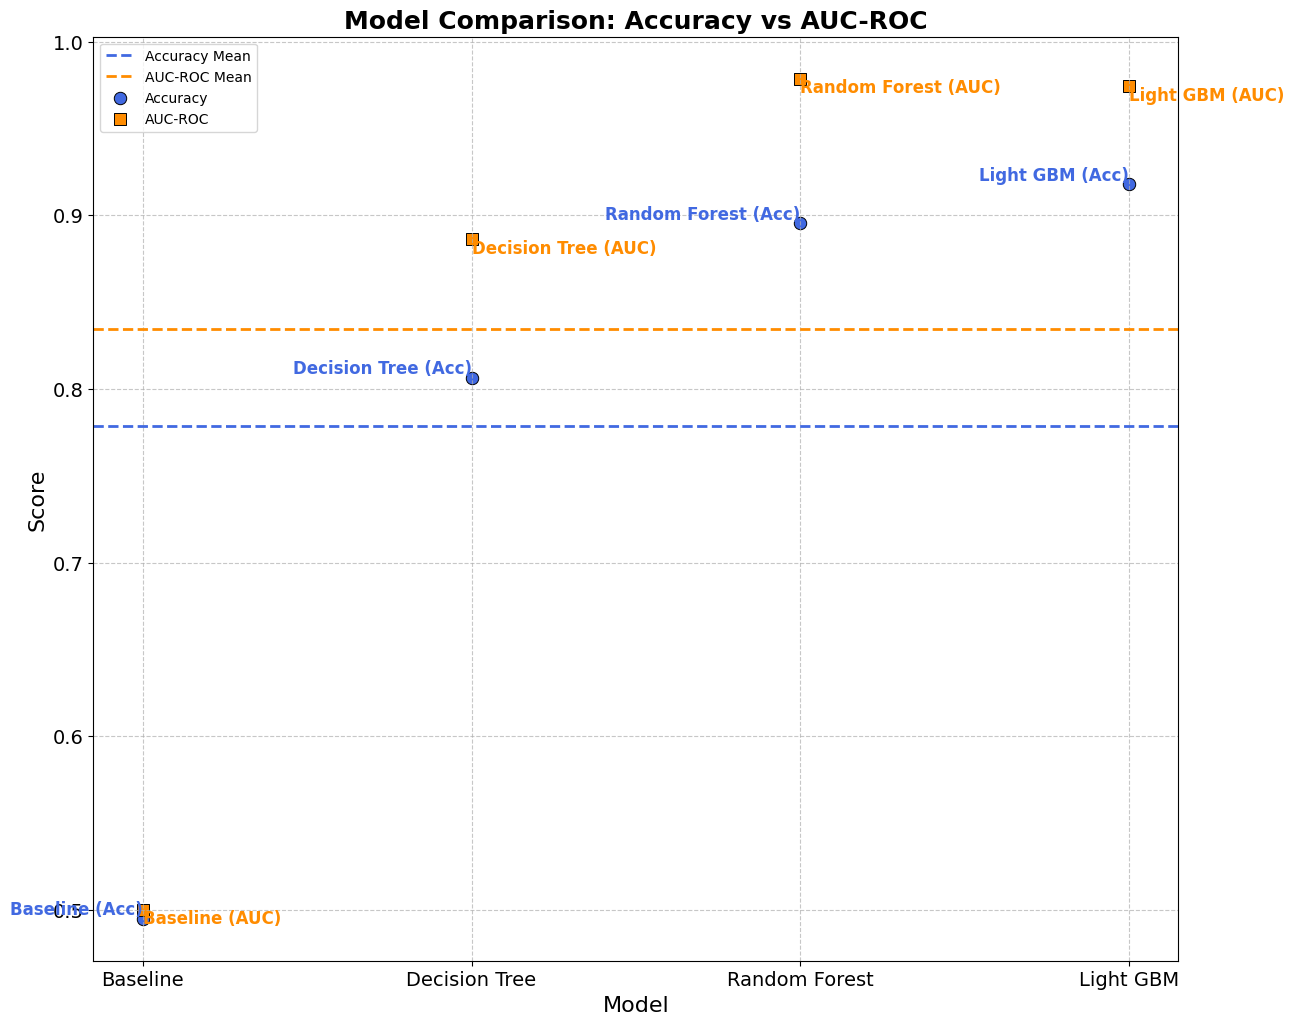

In [51]:
# Create a visual of the different models

fig, ax = plt.subplots(figsize=(14, 12))  

# Plot Accuracy Scatter Plot
sns.scatterplot(
    x=df_results.index, 
    y=df_results['Accuracy'], 
    color='royalblue', 
    s=80, 
    ax=ax, 
    label='Accuracy', 
    edgecolor='black', 
    linewidth=0.7, 
    marker='o'
)

# Plot AUC-ROC Scatter Plot
sns.scatterplot(
    x=df_results.index, 
    y=df_results['AUC-ROC'], 
    color='darkorange', 
    s=80, 
    ax=ax, 
    label='AUC-ROC', 
    edgecolor='black', 
    linewidth=0.7, 
    marker='s'
)

# Add annotations for each point
for i in range(df_results.shape[0]):
    ax.text(
        df_results.index[i], 
        df_results['Accuracy'][i], 
        f'{df_results.index[i]} (Acc)', 
        fontsize=12, ha='right', 
        va='bottom', 
        color='royalblue', 
        fontweight='bold'
    )
    
    ax.text(
        df_results.index[i], 
        df_results['AUC-ROC'][i], 
        f'{df_results.index[i]} (AUC)', 
        fontsize=12, 
        ha='left', 
        va='top', 
        color='darkorange', 
        fontweight='bold'
    )

# Add horizontal and vertical lines for reference
ax.axhline(
    y=df_results['Accuracy'].mean(), 
    color='royalblue', 
    linestyle='--', 
    linewidth=2, 
    label='Accuracy Mean'
)

ax.axhline(
    y=df_results['AUC-ROC'].mean(), 
    color='darkorange', 
    linestyle='--', 
    linewidth=2, 
    label='AUC-ROC Mean'
)

# Title and labels
plt.title('Model Comparison: Accuracy vs AUC-ROC', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)

ax.tick_params(axis='x', labelsize=14) 
ax.tick_params(axis='y', labelsize=14)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Based on the performance metrics, the LightGBM model and the Random Forest model are the top contenders. Ultimately, the LightGBM model will be selected for this task due to its exceptional AUC-ROC and accuracy. It delivers excellent predictive power and efficiently handles large datasets. Although it has a longer computation time compared to the Random Forest, its superior accuracy makes it the preferred choice.

## Model Evaluation

### Observing Best Hyperparameters

In [52]:
# Observe best LGB model 
best_lgb_model

LGBMClassifier(max_depth=15, n_estimators=150, num_leaves=50,
               random_state=12345, subsample=0.8)

### Final Model

In [53]:
%%time

# Create model
model = lgb.LGBMClassifier(
    random_state=12345,
    max_depth=15,
    n_estimators=150, 
    num_leaves=50,
    subsample=0.8
)

model.fit(X_train, y_train)
model_results = evaluate_model(model, X_test, y_test)

print(model_results, '\n')

{'AUC-ROC': 0.9793, 'Accuracy': 0.9355} 

CPU times: user 967 ms, sys: 22 ms, total: 989 ms
Wall time: 990 ms


## Summary

The project focused on developing a predictive model to address customer churn has yielded successful results. Beginning with meticulous data preparation, including managing class imbalance, performing feature engineering, and applying encoding and scaling techniques, the data was primed for effective model training.

Among the models evaluated, including Decision Tree, Random Forest and Logisitic Regression, LightGBM stood out for its superior performance. The model demonstrated its ability to handle large, high-dimensional datasets and produced highly accurate predictions. On the test set, LightGBM achieved an impressive AUC-ROC score of 0.9793 and an accuracy of 93.55%. These metrics highlight the model's strong capability to accurately identify customers at risk of churning.

With an AUC-ROC score of 0.9793, the model falls into the highest performance category, earning the maximum score of 6 SP according to the assessment criteria. This confirms LightGBM as a reliable and effective tool for predicting customer churn, enabling proactive measures to retain at-risk customers.

Looking ahead, the model is set to be deployed with a comprehensive strategy to ensure it continues to perform well in a production environment. This includes a robust data pipeline, scheduled retraining to adapt to changes in customer behavior, and continuous monitoring to maintain its effectiveness over time.

In summary, the LightGBM model has proven to be an excellent choice for addressing customer churn, delivering results that exceed expectations. The deployment and monitoring strategies in place will help leverage this model to reduce churn and improve customer retention, contributing to long-term business success.